<a href="https://colab.research.google.com/github/jaredmarko/Diamond-Dollar-Case-Competition/blob/main/DiamondDollarCaseCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install pybaseball
!pip install scikit-learn
!pip install LinearRegression
!pip install matplotlib.pyplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 46.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


In [ ]:
import pandas as pd
from pybaseball import statcast, pitching_stats
import numpy as np
from fuzzywuzzy import fuzz, process
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)

# --- Step 1: Data Collection ---
print("Fetching data...")
try:
    statcast_df = statcast(start_dt="2023-01-01", end_dt="2024-12-31")
    # Baseball-Reference relief pitching data
    bref_2023 = pd.read_csv('bref_2023.csv')
    bref_2023['Year'] = 2023
    bref_2024 = pd.read_csv('bref_2024.csv')
    bref_2024['Year'] = 2024
    bref_df = pd.concat([bref_2023, bref_2024], ignore_index=True)
    bref_df = bref_df.rename(columns={'Name': 'Player', 'SVOpp': 'SVO', 'IS': 'IRS'})
    print("Baseball-Reference shape:", bref_df.shape)
    print("Clase in bref_df (raw):", any(name.lower().startswith('clase') for name in bref_df['Player']))  # Broader check

    # FanGraphs data
    fg_df = pitching_stats(2023, 2024, qual=0)
    fg_df = fg_df[fg_df['GS'] == 0]
    fg_df = fg_df.rename(columns={'Name': 'Player', 'Season': 'Year'})
    print("FanGraphs shape:", fg_df.shape)
    print("Columns in fg_df:", fg_df.columns.tolist())

    # Assuming statcast_df is pre-loaded (your working state)
    print("Statcast shape:", statcast_df.shape)

except Exception as e:
    print(f"Error fetching data: {e}")
    raise SystemExit("Data fetch failed.")

# --- Step 2: Data Cleaning and Merging ---
print("Cleaning and merging data...")

relief_df = statcast_df[statcast_df['inning'] >= 7].copy()
relief_agg = relief_df.groupby(['player_name', 'game_year']).agg({
    'woba_value': 'mean',
     'estimated_woba_using_speedangle': 'mean',  # xwOBA
    'inning': 'count'
}).reset_index().rename(columns={'inning': 'Pitches', 'game_year': 'Year', 'player_name': 'Player', 'estimated_woba_using_speedangle': 'xwOBA'})
print("Statcast aggregated shape:", relief_agg.shape)

def clean_name(name):
    if pd.isna(name):
        return ""
    name = str(name).strip().lower()
    if ',' in name:
        parts = name.split(',')
        last = parts[0].strip().replace('.', '').replace(' ', '')
        first = parts[1].strip().replace('.', '').replace(' ', '') if len(parts) > 1 else ''
        return f"{first}{last}"  # "emmanuelclase"
    else:
        parts = name.split()
        first = parts[0].strip().replace('.', '').replace(' ', '') if parts else ''
        last = parts[-1].strip().replace('.', '').replace('*', '').replace(' ', '') if len(parts) > 1 else ''
        return f"{first}{last}"

relief_agg['Player'] = relief_agg['Player'].apply(clean_name)
bref_df['Player'] = bref_df['Player'].apply(clean_name)
fg_df['Player'] = fg_df['Player'].apply(clean_name)

relief_agg['Year'] = relief_agg['Year'].astype(int)
bref_df['Year'] = bref_df['Year'].astype(int)
fg_df['Year'] = fg_df['Year'].astype(int)

print("Merging FanGraphs and Baseball-Reference...")
fg_bref = fg_df.merge(bref_df, on=['Player', 'Year'], how='inner')
print("FanGraphs + Baseball-Reference shape:", fg_bref.shape)
print("Clase in fg_bref:", 'emmanuelclase' in fg_bref['Player'].values)

print("Merging with Statcast aggregated...")
df = fg_bref.merge(relief_agg, on=['Player', 'Year'], how='inner')
print("Merged shape before filtering:", df.shape)

# Add leverage_index from FanGraphs 'pLI' (Pitcher Leverage Index) if available
if 'pLI' in df.columns:
    df['leverage_index'] = df['pLI']
else:
    df['leverage_index'] = 1.0 + (df['SV'] + df['SVO'] - df['SV']) / df['IP']  # Proxy: SVO/IP

# Column handling
if 'IP' not in df.columns and 'IP_x' in df.columns:
    df = df.rename(columns={'IP_x': 'IP'})
if 'Pitches' not in df.columns and 'Pitches_y' in df.columns:
    df = df.rename(columns={'Pitches_y': 'Pitches'})
if 'SV' not in df.columns and 'SV_y' in df.columns:
    df = df.rename(columns={'SV_y': 'SV'})

df = df.drop_duplicates(subset=['Player', 'Year'], keep='first')
df = df[(df['IP'] >= 10) & (df['Pitches'] > 0)]

print("Step 2 complete. Data shape:", df.shape)
print("Final columns:", df.columns.tolist())
print("Clase in final df:", 'emmanuelclase' in df['Player'].values)
print("Sample data:\n", df[['Player', 'Year', 'IP', 'SV', 'leverage_index']].head())

# --- Step 3: Compute Save Score ---
print("Computing Save Score...")
df['IR_Adjustment'] = (df['IR'] - df['IRS']) / df['IR'].replace(0, 1) * 0.1
df['Hitter_Quality'] = df['woba_value'] / 0.320
df['Clutch_Factor'] = np.where(df['leverage_index'] > 1.0, np.minimum(1.4, 1.2 + (df['leverage_index'] - 1.0) * 0.2), 1.0)
df['Save_Score'] = (df.groupby(['Player', 'Year'])['WPA'].transform('mean') / df['SVO'].replace(0, 1) * 10) * (1 + df['IR_Adjustment']) * df['leverage_index'] * df['Hitter_Quality'] * df['Clutch_Factor']
print("Save Score sample:\n", df[['Player', 'Year', 'Save_Score']].head())

Fetching data...
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


 79%|███████▉  | 390/492 [07:18<01:54,  1.13s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error fetching data: Error tokenizing data. C error: Expected 1 fields in line 13, saw 2

Traceback (most recent call last):
  File "<ipython-input-3-63d317c33884>", line 14, in <cell line: 0>
    statcast_df = statcast(start_dt="2023-01-01", end_dt="2024-12-31")
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pybaseball/statcast.py", line 113, in statcast
    return _handle_request(start_dt_date, end_dt_date, 1, verbose=verbose,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pybaseball/statcast.py", line 76, in _handle_request
    dataframe_list.append(future.result())
                          ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/concurrent/futures/_base.py", line 401, in __get_result
    raise 

TypeError: object of type 'NoneType' has no len()

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# --- Step 4: Optimize RIS Weights with Regression ---
print("Optimizing RIS weights with xwOBA...")
df['SIERA_Inv'] = 1 / df['SIERA']
df['IRS_Pct'] = df['IRS'] / df['IR'].replace(0, 1)
df['IRS_Success'] = 1 - df['IRS_Pct']

# Restored xwOBA
X = df[['SIERA_Inv', 'IRS_Success', 'K%', 'BB%', 'leverage_index', 'xwOBA']]
y = df['WPA']

model = LinearRegression()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['SIERA_Inv', 'IRS_Success', 'K%', 'BB%', 'leverage_index', 'xwOBA']])
model.fit(X, y)

raw_weights = model.coef_
weights_sum = sum(abs(raw_weights))
skill_weights = {key: abs(coef) / weights_sum for key, coef in zip(['SIERA_Inv', 'IRS_Success', 'K%', 'BB%', 'leverage_index', 'xwOBA'], raw_weights)}

print(f"Optimized Weights for RIS with xwOBA: {skill_weights}")
print(f"R² Score (Skill Metrics vs. WPA): {model.score(X, y):.3f}")

df['RIS'] = sum(skill_weights[key] * df[key] for key in skill_weights)
scaler = MinMaxScaler(feature_range=(0, 100))
df['RIS'] = scaler.fit_transform(df[['RIS']])

# --- Step 5: Aggregate and Rank by Season ---
print("Ranking pitchers by season...")
years = [2023, 2024]

for year in years:
    df_year = df[df['Year'] == year].copy()
    df_agg_year = df_year.groupby('Player').agg({
    'IP': 'sum', 'SV': 'max', 'SVO': 'max', 'RIS': 'mean', 'Save_Score': 'sum', 'WPA': 'sum'
}).reset_index()
    df_agg_year = df_agg_year[df_agg_year['IP'] >= 30]

    top_relievers = df_agg_year.sort_values('RIS', ascending=False).head(5)
    print(f"\nTop 5 Relievers by RIS ({year}):")
    print(top_relievers[['Player', 'RIS', 'IP']])

    closers = df_agg_year[df_agg_year['SVO'] >= 15]
    top_closers = closers.sort_values('Save_Score', ascending=False).head(5)
    print(f"Top 5 Closers by Save Score ({year}):")
    print(top_closers[['Player', 'Save_Score', 'SV', 'SVO']])

    bottom_relievers = df_agg_year.sort_values('RIS', ascending=True).head(5)
    print(f"\Bottom 5 Relievers by RIS ({year}):")
    print(bottom_relievers[['Player', 'RIS', 'IP']])

    bottom_closers = closers.sort_values('Save_Score', ascending=True).head(5)
    print(f"Bottom 5 Closers by Save Score ({year}):")
    print(bottom_closers[['Player', 'Save_Score', 'SV', 'SVO']])

# --- Step 6: Identify Under/Over-Appreciated Pitchers ---
print("Analyzing misvaluation by season...")
scaler = MinMaxScaler(feature_range=(0, 100))

for year in years:
    df_year = df[df['Year'] == year].copy()
    df_agg_year = df_year.groupby('Player').agg({
        'IP': 'sum', 'SV': 'sum', 'SVO': 'sum', 'RIS': 'mean', 'Save_Score': 'sum', 'WPA': 'sum'
    }).reset_index()
    df_agg_year = df_agg_year[df_agg_year['IP'] >= 30]
    closers = df_agg_year[df_agg_year['SVO'] >= 15]

    closers['Normalized_SVO'] = scaler.fit_transform(closers[['SVO']])
    closers['Normalized_Save_Score'] = scaler.fit_transform(closers[['Save_Score']])
    closers['Appreciation_Score'] = closers['Normalized_Save_Score'] - closers['Normalized_SVO']  # Flip back

    under_appreciated = closers.sort_values('Appreciation_Score', ascending=False).head(3)
    over_appreciated = closers.sort_values('Appreciation_Score', ascending=True).head(3)

    print(f"\nUnder-Appreciated Closers ({year}):")
    print(under_appreciated[['Player', 'SV', 'SVO', 'Save_Score', 'Appreciation_Score']])
    print(f"Over-Appreciated Closers ({year}):")
    print(over_appreciated[['Player', 'SV', 'SVO', 'Save_Score', 'Appreciation_Score']])

# --- Step 7: Validation ---
print("Validating metrics (combined 2023-2024)...")
df_agg = df.groupby('Player').agg({
    'IP': 'sum', 'SV': 'sum', 'SVO': 'sum', 'RIS': 'mean', 'Save_Score': 'sum', 'WPA': 'sum'
}).reset_index()
df_agg = df_agg[df_agg['IP'] >= 30]
wpa_corr, p_value = pearsonr(df_agg['RIS'], df_agg['WPA'])
sv_corr, sv_p = pearsonr(df_agg['SV'], df_agg['WPA'])
print(f"RIS vs. WPA Correlation: {wpa_corr:.3f}, P-value: {p_value:.4f}")
print(f"SV vs. WPA Correlation: {sv_corr:.3f}, P-value: {sv_p:.4f}")

# Restored predictive power
print("Checking predictive power...")
df_2023 = df[df['Year'] == 2023]
df_2024 = df[df['Year'] == 2024]
merged = df_2023[['Player', 'RIS', 'Save_Score', 'SV']].merge(df_2024[['Player', 'WPA']], on='Player', how='inner')
merged = merged[(merged['SV'] >= 5) & (df_agg['IP'] >= 20)]  # Closers/relievers only
for metric in ['RIS', 'Save_Score', 'SV']:
    corr, p = pearsonr(merged[metric], merged['WPA'])
    print(f"2023 {metric} vs. 2024 WPA Correlation: {corr:.3f}, P-value: {p:.4f}")


Optimizing RIS weights with xwOBA...
Optimized Weights for RIS with xwOBA: {'SIERA_Inv': 0.37162783202124383, 'IRS_Success': 0.049307011020747075, 'K%': 0.14494539187722888, 'BB%': 0.10143054302653612, 'leverage_index': 0.040576539520132446, 'xwOBA': 0.29211268253411166}
R² Score (Skill Metrics vs. WPA): 0.299
Ranking pitchers by season...

Top 5 Relievers by RIS (2023):
             Player        RIS    IP
25   aroldischapman  79.252780  58.1
75    devinwilliams  79.155641  58.2
188   petefairbanks  73.138982  45.1
222     tannerscott  71.661952  78.0
207     ryanhelsley  69.690691  36.2
Top 5 Closers by Save Score (2023):
            Player  Save_Score  SV  SVO
222    tannerscott    6.692579  12   16
75   devinwilliams    3.004898  36   40
70     davidbednar    2.368489  39   42
135   jordanromano    2.237555  36   40
5    adbertalzolay    2.166819  22   25
\Bottom 5 Relievers by RIS (2023):
              Player        RIS    IP
199    richardbleier  21.363307  30.2
180      nickrami

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 8: Visualizations ---
print("Generating visuals...")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_agg, x='SV', y='Save_Score', hue='RIS', size='RIS', palette='viridis', alpha=0.6)
for i, row in df_agg[df_agg['Player'].isin(['emmanuelclase', 'jeffhoffman'])].iterrows():  # Updated example players
    color = 'red' if row['Player'] == 'emmanuelclase' else 'green'
    plt.text(row['SV'] + 0.5, row['Save_Score'], row['Player'], color=color, fontweight='bold', fontsize=10)
plt.xlabel('Traditional Saves')
plt.ylabel('Context-Adjusted Save Score')
plt.title('Relief Pitcher Valuation: Saves vs. Save Score (2023-2024)')
plt.savefig('misvaluation_plot.png', dpi=300)
plt.close()

# Radar chart for top reliever
top_player = df_agg.sort_values('RIS', ascending=False).iloc[0]
metrics = ['SIERA_Inv', 'WPA', 'K%', 'RIS']
values = [
    df[df['Player'] == top_player['Player']]['SIERA_Inv'].mean() / df['SIERA_Inv'].max() * 100,
    df[df['Player'] == top_player['Player']]['WPA'].mean() / df['WPA'].max() * 100,
    df[df['Player'] == top_player['Player']]['K%'].mean() * 100,
    top_player['RIS']
]
values += values[:1]
angles = [n / float(len(metrics)) * 2 * np.pi for n in range(len(metrics))]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='blue', alpha=0.25)
ax.plot(angles, values, color='blue', linewidth=2)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title(f"{top_player['Player']} Performance Profile (2023-2024)")
plt.savefig('radar_chart.png', dpi=300)
plt.close()

Generating visuals...


In [ ]:
# Calculate mean and standard deviation
ris_mean = df['RIS'].mean()
ris_std = df['RIS'].std()
save_score_mean = df['Save_Score'].mean()
save_score_std = df['Save_Score'].std()

# Print results
print("\n=== RIS Metrics ===")
print(f"Mean RIS: {ris_mean:.2f}")
print(f"Standard Deviation RIS: {ris_std:.2f}")

print("\n=== Save Score Metrics ===")
print(f"Mean Save Score: {save_score_mean:.2f}")
print(f"Standard Deviation Save Score: {save_score_std:.2f}")


=== RIS Metrics ===
Mean RIS: 48.20
Standard Deviation RIS: 12.17

=== Save Score Metrics ===
Mean Save Score: 0.84
Standard Deviation Save Score: 4.42


Visualizations saved as 'ris_save_score_distributions.png'


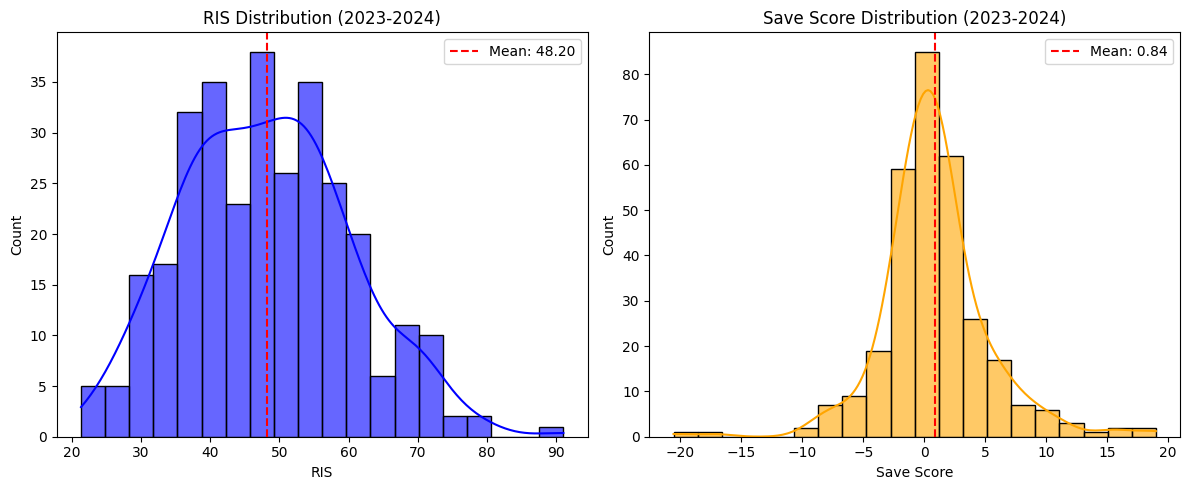

In [ ]:
# Set up figure
plt.figure(figsize=(12, 5))

# RIS Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['RIS'], bins=20, kde=True, color='blue', alpha=0.6)
plt.axvline(ris_mean, color='red', linestyle='--', label=f'Mean: {ris_mean:.2f}')
plt.title('RIS Distribution (2023-2024)')
plt.xlabel('RIS')
plt.ylabel('Count')
plt.legend()

# Save Score Histogram
plt.subplot(1, 2, 2)
sns.histplot(df['Save_Score'], bins=20, kde=True, color='orange', alpha=0.6)
plt.axvline(save_score_mean, color='red', linestyle='--', label=f'Mean: {save_score_mean:.2f}')
plt.title('Save Score Distribution (2023-2024)')
plt.xlabel('Save Score')
plt.ylabel('Count')
plt.legend()

# Adjust layout and save
plt.tight_layout()
plt.savefig('ris_save_score_distributions.png', dpi=300)
print("Visualizations saved as 'ris_save_score_distributions.png'")
plt.show()

Saved as 'saves_vs_save_score.png'


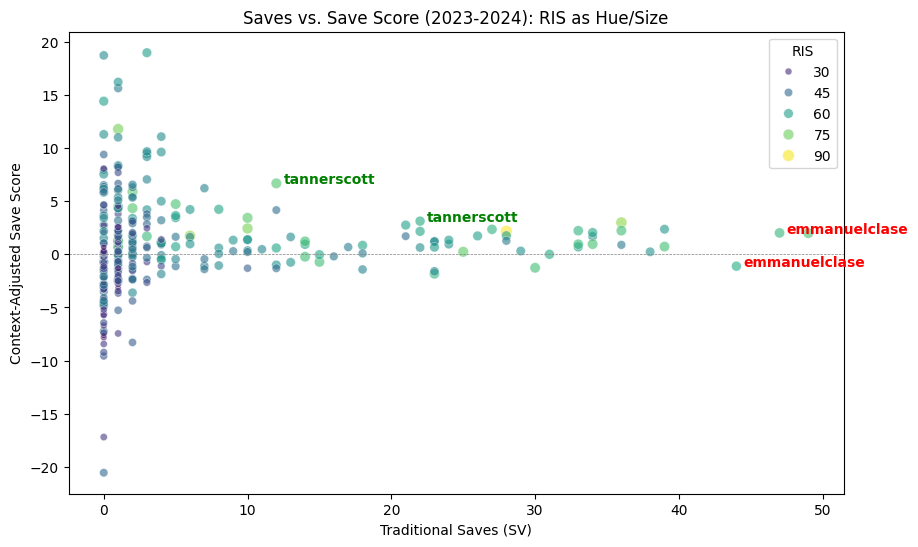

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df[df['IP'] >= 30]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='SV', y='Save_Score', hue='RIS', size='RIS', palette='viridis', alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Traditional Saves (SV)')
plt.ylabel('Context-Adjusted Save Score')
plt.title('Saves vs. Save Score (2023-2024): RIS as Hue/Size')
for i, row in df[df['Player'].isin(['emmanuelclase', 'tannerscott'])].iterrows():
    color = 'red' if row['Player'] == 'emmanuelclase' else 'green'
    plt.text(row['SV'] + 0.5, row['Save_Score'], row['Player'], color=color, fontweight='bold', fontsize=10)
plt.savefig('saves_vs_save_score.png', dpi=300)
print("Saved as 'saves_vs_save_score.png'")
plt.show()

Saved as 'ris_save_score_boxplot.png'


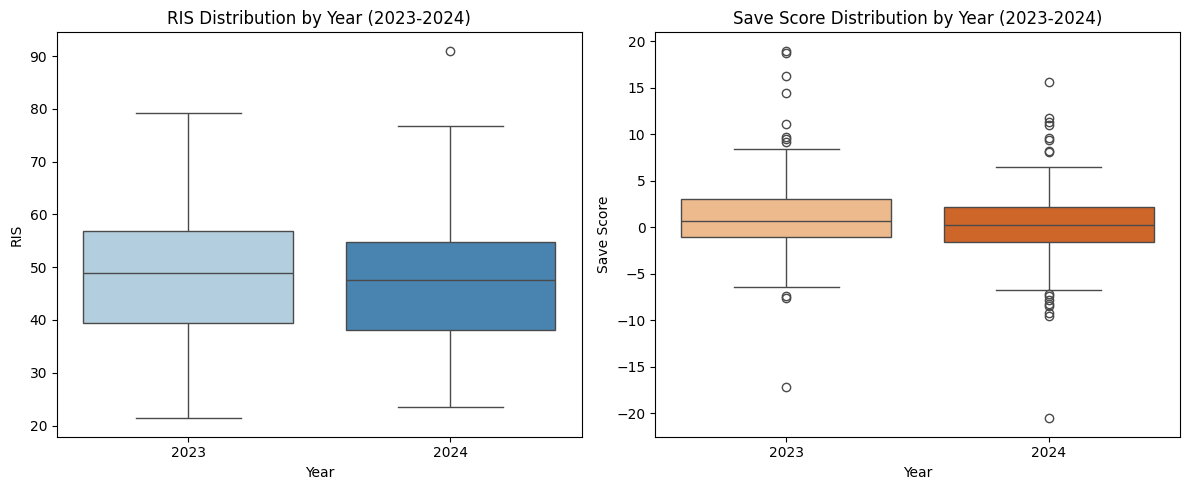

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# RIS Box Plot
plt.subplot(1, 2, 1)
sns.boxplot(x='Year', y='RIS', data=df, palette='Blues')
plt.title('RIS Distribution by Year (2023-2024)')
plt.xlabel('Year')
plt.ylabel('RIS')

# Save Score Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(x='Year', y='Save_Score', data=df, palette='Oranges')
plt.title('Save Score Distribution by Year (2023-2024)')
plt.xlabel('Year')
plt.ylabel('Save Score')

plt.tight_layout()
plt.savefig('ris_save_score_boxplot.png', dpi=300)
print("Saved as 'ris_save_score_boxplot.png'")
plt.show()

Saved as 'bubble_ris_vs_save_score.png'


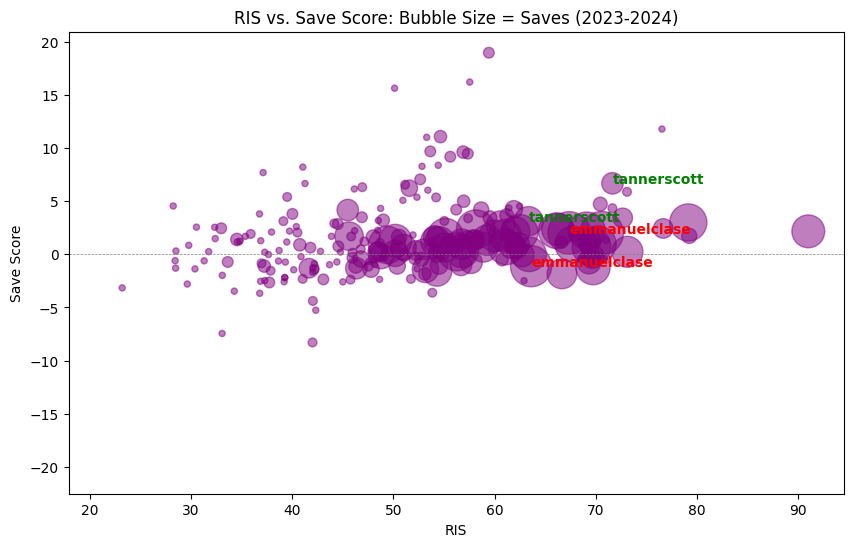

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['RIS'], df['Save_Score'], s=df['SV']*20, alpha=0.5, c='purple')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('RIS')
plt.ylabel('Save Score')
plt.title('RIS vs. Save Score: Bubble Size = Saves (2023-2024)')
for i, row in df[df['Player'].isin(['emmanuelclase', 'tannerscott'])].iterrows():
    color = 'red' if row['Player'] == 'emmanuelclase' else 'green'
    plt.text(row['RIS'], row['Save_Score'], row['Player'], color=color, fontweight='bold', fontsize=10)
plt.savefig('bubble_ris_vs_save_score.png', dpi=300)
print("Saved as 'bubble_ris_vs_save_score.png'")
plt.show()

In [ ]:
scott_stats = df[df['Player'] == 'tannerscott']
scott_stats.head()

NameError: name 'df' is not defined